# Mount dysk konta google do notebooka

In [2]:
from google.colab import drive
drive.flush_and_unmount()  # Unmount the drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install mne

---
# Legenda:

<font color="lightgreen">▬ </font>Teoria<br>
<font color="lightblue">▬ </font>Cytaty z artykułu<br>
<font color="pink">▬ </font>Implementacja<br>

---

# <font color="lightgreen"> Architektura modeli</font>

(Wszystko w kursywie koloru niebieskiego jest z artykułu.)

<font color="lightblue">*The network consisted of Transformer
 modules as well as operations of Positional Embedding.
 We also designed methods that combined the CNN module
 and the Transformer module. CNN was included because
 of its good properties for feature representation [5].*</font>

 <font color="lightblue">*In the implementation, we built a total of **five** Transformer-based
 models in which two models only relied on the Transformer
 without including the CNN and three models used network
 architecture of combined CNN and Transformer. After the
 CNN and the Transformer modules, we included a fully
connected layer.*

*In this study, we employed **h = 8 parallel attention layers
 (so-called 8 attention heads)**, and solely embedded the encoder
 part of Transformer into the EEG classification.*</font>

---

 <font color="lightblue">*The Transformer module had two submodules. The
 first submodule included a multi-head attention layer followed
 by a normalization layer. The second submodule included a
 position-wise fully connected feed-forward layer followed by
 a normalization layer. The residual connection was employed
 around each of the two submodules.*</font>


<img src="https://builtin.com/sites/www.builtin.com/files/styles/ckeditor_optimize/public/inline-images/Transformer-neural-network-12.png" width="400">

# <font color='lightgreen'>Terminologia</font>

*   **Gradient** - mierzy zmianę wszystkich wag w odniesieniu do zmiany błędu
*   **Funkcja aktywacji** - kiedy budujemy sieć nueronową, musimy zdecydować, jaką taka funkcjębędziemy używać.
Duża ilość ludzi używa Funkcji sigmoidalnej, ale w praktyce częściej używa się ReLU, albo Softplus

*   **ReLU** - Jest ona zdefiniowana jako f(x) = max(0, x), co oznacza, że ​​wyprowadza ona wartość wejściową bezpośrednio, jeśli jest dodatnia, a zero w przeciwnym wypadku. Bez niej, sieć neuronowa byłaby po prostu... jednym wielkim wzorem liniowym.

```python
    # feed-forward layer
    self.ff = nn.Sequential(
        # This changes the size of each input vector from d_model (e.g. 64) to 512.
        nn.Linear(d_model, 512),
        nn.ReLU(), # Without it, the two Linear layers would just collapse into a single linear function (no point).
        nn.Linear(512, d_model) #wraca do początkowego wymiaru, bo reszta transformera wymaga rozmiaru d_model
    )
        


```


*   **Attention** - The key/value/query concept is analogous to retrieval systems. For example, when you search for videos on Youtube, the search engine will map your query (text in the search bar) against a set of keys (video title, description, etc.) associated with candidate videos in their database, then present you the best matched videos (values).

  ---
  Spatial Transformer (s-Trans)
  You treat channels (electrodes) as the sequence.
  Each vector = EEG signal from a channel across time
  
  So: each channel attends to other channels
  → “What can I learn from other electrodes?”
  
  ---
  Temporal Transformer (t-Trans)
  Now, you treat time points as the sequence.

  Each vector = EEG signal from all channels at one time point

  So: each time point attends to other time points → “What’s important in the signal over time?”

*   **Feed forward** - najwcześniejsza i najprostsza forma sieci neuronowej. Dane są podawane do przodu (fed forward) z jednej warsty do następnej. Występuje po wartswie attention. Dostajemy na input znormalizowany output z attention.
  
  *In the context of transformers, the feed-forward network is a sub-unit within each encoder and decoder layer. It takes the output from the self-attention layer, which captures relationships between different parts of the input sequence, and transforms it further*
  
  Dodaje kolejną warstwę złożoności, stosując funkcje nieliniowe do tych reprezentacji. Dzięki temu model może uczyć się bardziej skomplikowanych wzorców w danych.
  
  Może być również postrzegana jako sposób na udoskonalenie cech wyodrębnionych przez warstwę samouwagi. Może podkreślać ważne cechy i tłumić mniej istotne, dzięki czemu końcowy wynik jest bardziej pouczający.
  
  src = https://medium.com/@punya8147_26846/understanding-feed-forward-networks-in-transformers-77f4c1095c67


*  **Conv2d** :<br>
  **KERNEL** - opisuje filtr, który zamierzamy przekazać (w przypadku obrazów) na obraz wejściowy.

  <br><img src="https://miro.medium.com/v2/resize:fit:828/format:webp/0*A0hPszjXFj1S2FZ6.png" width="500">
  <br><img src="https://miro.medium.com/v2/resize:fit:786/format:webp/1*LT0l-KXw5FXIkcGVl-KXlQ.gif" width="500">

  W EEG mając
   ```python
  X shape: (batch, 1, 64, 481)  # ← means:
  # batch = 32
  # 1 input channel (grayscale EEG)
  # 64 EEG channels (spatial dimension)
  # 481 time points (temporal dimension)
   ```
  Mamy na dobrą sprawę "obrazki" EEG w wymiarze 64 x 481

  Pisząc
  ```python
  nn.Conv2d(1, 64, (64, 1))
  ```

  Oczekujemy 1 kanału na input<br>
  CNN nauczy się 64 takich filtrów<br>
  Kernel widzi 64 wiersze x 1 kolumnę, czyli wszystkie kanały naraz







# <font color="pink"> Moduł Transformera</font>


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F


"""
d_model -> wymiar wektorów osadzonych (embeddingów)
ReLU    -> to funkcja aktywacji (tutorial: https://www.youtube.com/watch?v=68BZ5f7P94E)
norm1 i norm2 -> To są warstwy Layer Normalization, normalizują dane na poziomie każdej próbki

"""
class TransformerBlock(nn.Module):
  def __init__(self, d_model, nhead):
    super(TransformerBlock, self).__init__()
    self.attn = nn.MultiheadAttention(d_model, nhead, dropout=0.3)

    # feed-forward layer
    self.ff = nn.Sequential(
        nn.Linear(d_model, 512),
        nn.ReLU(),
        nn.Linear(512, d_model)
    )

    self.norm1 = nn.LayerNorm(d_model)
    self.norm2 = nn.LayerNorm(d_model)

  def forward(self, x):

    # output, _ = attention(query=x, key=x, value=x)
    attn_output, _ = self.attn(x, x, x)

    """
    x + attn_output -> to residual connection, czyli technika projektowania sieci neuronowych,
    która pozwala warstwom pomijać się nawzajem, co pomaga w szkoleniu głębszych sieci.
    Dodajesz oryginalne dane wejściowe (x) do danych wyjściowych uwagi.

    It lets the model say:
    “I’ll keep most of what I had, and only adjust a little.”

    It helps the gradient flow backward during training.
    """
    x = self.norm1(x + attn_output)
    ff_output = self.ff(x)
    x = self.norm2(x + ff_output)
    return x


# Jak tego używamy

```
Input x
 ↓
Multi-head attention
 ↓
x = x + attention_output        ← residual
x = LayerNorm(x)                ← normalization
 ↓
Feed-forward
 ↓
x = x + feedforward_output      ← residual
x = LayerNorm(x)                ← normalization

```
| Line of Code                            | What it Does                       | Why It's Important                                                                 |
|----------------------------------------|------------------------------------|------------------------------------------------------------------------------------|
| `attn_output, _ = self.attn(x, x, x)`  | Applies multi-head self-attention | Learns dependencies across time or channels (e.g. between electrodes or moments)  |
| `x = self.norm1(x + attn_output)`      | Residual + LayerNorm               | Makes training stable and allows deeper models by preserving gradient flow        |
| `ff_output = self.ff(x)`               | Feed-forward network               | Applies non-linear transformation at each position (enriches representation)      |
| `x = self.norm2(x + ff_output)`        | Another residual + LayerNorm       | Further stabilization and refined representation                                  |
| `return x`                             | Returns transformed output         | Feeds the improved signal into the next layer or classifier                       |

<br>
<br>


Używamy trzechy modułów Transformera:<br>
<font color="lightblue">*We explored the influence of the number of Transformer modules on the classification results. The number of Transformer modules was tested from 1 to 6. When the number of 3 was chosen, the classification achieved the best results. We therefore included three Transformer modules in our models.*</font>

```python
# Czyli np
class SpatialTransformer(nn.Module):
    def __init__(...):
        ...
        self.transformer = nn.Sequential(
            TransformerBlock(d_model, nhead),
            TransformerBlock(d_model, nhead),
            TransformerBlock(d_model, nhead)
        )


```

# <font color="pink"> Positional encoding</font>





In [5]:
class PositionalEncoding(nn.Module):
  # 1000, bo dla 3s mamy 480 próbek, dla 6s 960 (physionet)
  def __init__(self, d_model, max_len=1000):
    super(PositionalEncoding, self).__init__()
    pe = torch.zeros(max_len, d_model)
    position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
    # For even indices (dimension 2i):
    # PE(pos, 2i) = sin(pos / (10000^(2i / d_model))) ---> (10000^(2i / d_model)) === div_term
    pe[:, 0::2] = torch.sin(position * div_term)
    # For odd indices (dimension 2i+1):
    # PE(pos, 2i+1) = cos(pos / (10000^(2i / d_model)))
    pe[:, 1::2] = torch.cos(position * div_term)

    pe = pe.unsqueeze(0).transpose(0, 1)
    self.register_buffer('pe', pe)

  def forward(self, x):
    return x + self.pe[:x.size(0), :]

# <font color="pink"> Spatial Transformer</font>





In [6]:
# Learns dependencies between channel
class SpatialTransformer(nn.Module):
  def __init__(self, input_size, d_model, nhead, num_classes):
    super(SpatialTransformer, self).__init__()
    self.embedding = nn.Linear(input_size, d_model)
    self.pos_encoder = PositionalEncoding(d_model)
    self.transformer = nn.Sequential(
        TransformerBlock(d_model, nhead),
        TransformerBlock(d_model, nhead),
        TransformerBlock(d_model, nhead)
    )
    self.fc = nn.Linear(d_model, num_classes)

  def forward(self, x):
    x = x.permute(1, 0, 2) # (channels, batch, time)
    x = self.embedding(x)
    x = self.pos_encoder(x)
    x = self.transformer(x)
    x = x.mean(dim=0)
    return self.fc(x)


# <font color="pink"> Temporal Transformer</font>









In [7]:
# Transformer learns relationships between time points
class TemporalTransformer(nn.Module):
    def __init__(self, input_size, d_model, nhead, num_classes):
        super(TemporalTransformer, self).__init__()
        self.embedding = nn.Linear(input_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        self.transformer = nn.Sequential(
            TransformerBlock(d_model, nhead),
            TransformerBlock(d_model, nhead),
            TransformerBlock(d_model, nhead)
        )
        self.fc = nn.Linear(d_model, num_classes)

    def forward(self, x):  # x shape: (batch, channels, time)
        x = x.permute(2, 0, 1)  # (time, batch, channels)
        x = self.embedding(x)
        x = self.pos_encoder(x)
        x = self.transformer(x)
        x = x.mean(dim=0)
        return self.fc(x)

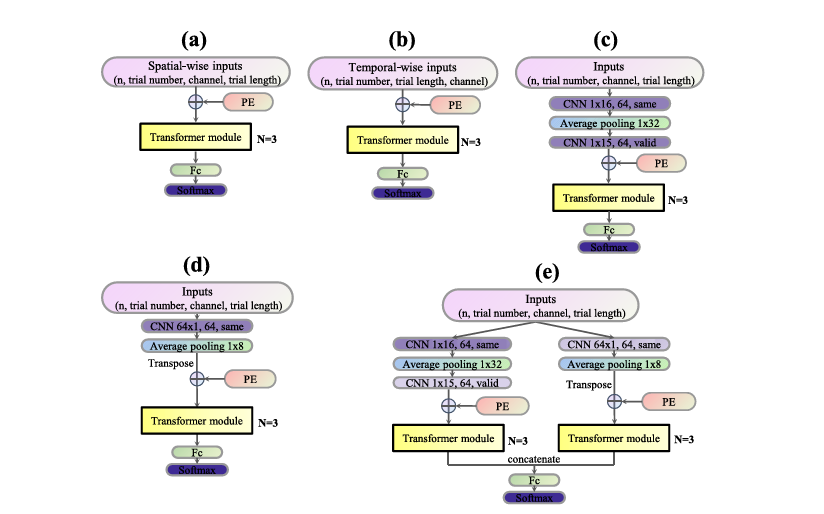

# <font color="pink"> Spatial CNN Transformer</font>


  <font color="lightblue">*In the spatial implementation of the CNN + Transformer
 model (s-CTrans, Fig. 3c), the CNN module included two
 convolutional layers and one average pooling layer. In the first
 convolutional layer, we used 64 kernels with the size of 1 × 16
 (channel × time points) to extract EEG temporal information,
 and adopted the SAME padding. The average pooling layer
 had the pooling size of 1 × 32. The second convolutional
 layer used 64 kernels with the size of 1 × 15, and adopted
 the VALID padding*</font>







In [8]:
# Uses CNN to help extract temporal features per channel, then model channel relations
class SpatialCNNTransformer(nn.Module):
    def __init__(self, input_size, d_model, nhead, num_classes):
        super(SpatialCNNTransformer, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 64, (1, 16), padding='same'),
            nn.ReLU(),
            nn.AvgPool2d((1, 32)),
            nn.Conv2d(64, 64, (1, 15)),
            nn.ReLU()
        )
        self.embedding = nn.Linear(64, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        self.transformer = nn.Sequential(*[TransformerBlock(d_model, nhead) for _ in range(3)])
        self.fc = nn.Linear(d_model, num_classes)

    def forward(self, x):  # x shape: (batch, 1, channels, time)
        x = self.cnn(x).squeeze(3).permute(2, 0, 1)
        x = self.embedding(x)
        x = self.pos_encoder(x)
        x = self.transformer(x)
        x = x.mean(dim=0)
        return self.fc(x)


# <font color="pink"> Temporal CNN Transformer</font>

  <font color="lightblue">*In the temporal implementation of the CNN + Transformer
 model (t-Ctrans, Fig 3d), the CNN module included one
 convolutional layer and one average pooling layer. The con
volutional layer used 64 kernels with the size of 64 × 1(chan
nel × time points) to extract EEG spatial information, and
 adopted the SAME padding. The average pooling layer had
 the pooling size of 1 × 8. After the average pooling layer,
 we transposed the features.*</font>


In [9]:
# Uses CNN to help extract spatial features per time point, then model time dynamics
class TemporalCNNTransformer(nn.Module):
    def __init__(self, input_size, d_model, nhead, num_classes):
        super(TemporalCNNTransformer, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=(64, 1), padding='same'),
            nn.ReLU(),
            nn.AvgPool2d((1, 8))
        )
        self.embedding = nn.Linear(64, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        self.transformer = nn.Sequential(*[TransformerBlock(d_model, nhead) for _ in range(3)])
        self.fc = nn.Linear(d_model, num_classes)

    def forward(self, x):  # x shape: (batch, 1, channels, time)
        x = self.cnn(x)               # → (B, 64, 1, T_new)
        x = x.mean(dim=2)             # → (B, 64, T_new)
        x = x.permute(2, 0, 1)        # (time, batch, features)
        x = self.embedding(x)
        x = self.pos_encoder(x)
        x = self.transformer(x)
        x = x.mean(dim=0)
        return self.fc(x)



# <font color="pink"> FusionCNNTransformer</font>

In [11]:
# Combine best both spatial and temporal CNN Transformer
class FusionCNNTransformer(nn.Module):
    def __init__(self, input_size, d_model, nhead, num_classes):
        super(FusionCNNTransformer, self).__init__()
        self.s_cnn = SpatialCNNTransformer(input_size, d_model, nhead, num_classes)
        self.t_cnn = TemporalCNNTransformer(input_size, d_model, nhead, num_classes)
        self.fc = nn.Linear(num_classes * 2, num_classes)

    def forward(self, x):
        spatial_out = self.s_cnn(x)
        temporal_out = self.t_cnn(x)
        fusion = torch.cat((spatial_out, temporal_out), dim=1)
        return self.fc(fusion)

---

# <font color="pink"> Przygotowanie danych do treningu w PyTorch</font>

In [10]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

class EEGDataset(Dataset):
  def __init__(self, X, y, cnn_mode=False):
    self.X = torch.tensor(X, dtype=torch.float32)
    if cnn_mode:
      # Bo modele CNN potrzebuja 4D na feature
      self.X = self.X.unsqueeze(1)
    self.y = torch.tensor(y, dtype=torch.long)
  def __len__(self):
      return len(self.X)
  def __getitem__(self, idx):
    return self.X[idx], self.y[idx]


---

# <font color="pink">Implentacja Within-Individual Training</font>

In [12]:
!pip install torchmetrics
!pip install mne



*Training Parameter Settings:*
<font color="lightblue">
* *Empirically, the number of
 head in each multi-head attention layer was set to 8 [25].*
* *The dropout rate was set to 0.3.*
* *The parameter of the position-wise fully connected feed-forward layer with a ReLU activation was set to 512.*
* *The weight attenuation was 0.0001.*
* *All the models used the Adam optimizer. The training epoch was set
 to 50.*
* *We set the number of training epochs to 10*
* *The EEG data were transformed into 3D tensors (N, C, T), where N is the number of trials, C is the number of channels, and T is the time points.*
* *In our Transformer-based models,
 we set dk = dv = 64, which was the same size as EEG
 channel numbers.*</font>



In [13]:
import mne
import os
import csv
import numpy as np
from torchmetrics.classification import Accuracy


preprocessed_data_dir ="/content/drive/My Drive/EEG_Data/Physionet"
d_model = 64
nhead = 8
num_classes = 2
batch_size = 32
num_epochs = 50
weight_decay=1e-4
cnn_models = {"SpatialCNNTransformer", "TemporalCNNTransformer", "FusionCNNTransformer"}

def load_subject_data(file_path) ->tuple[np.ndarray, np.ndarray]:
    epochs = mne.read_epochs(file_path, preload=True)
    """
    Number of epochs, channels, n_times -> Liczba punktów czasowych w jednym epizodzie EEG (czyli długość sygnału w czasie).
                                          Dla danych 3-sekundowych:
                                          EEG było próbkowane z częstotliwością 160 Hz

                                          3 sekundy × 160 Hz = 480 punktów

                                          Więc: n_times = 480

                                          Dla danych 6-sekundowych:
                                          6 sekundy × 160 Hz = 960 punktów

                                          Więc: n_times = 960
    """
    X = epochs.get_data()

    # Labels
    y = epochs.events[:, -1]

    # Labels should be numered 0, 1, 2 ...
    y = np.array([0 if label == 2 else 1 for label in y])
    return X, y


def train_model(model, train_loader, test_loader, device, lr):
  model.to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=7e-4, weight_decay=1e-4)
  criterion = torch.nn.CrossEntropyLoss()

  for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
      X_batch, y_batch = X_batch.to(device), y_batch.to(device)
      optimizer.zero_grad()
      output = model(X_batch)
      loss = criterion(output, y_batch)
      loss.backward()
      optimizer.step()
      total_loss += loss.item()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss:.4f}")


def evaluate_model(model, test_loader, device)-> float:
  acc = Accuracy(task='binary').to(device)
  model.eval()

  with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        output = model(X_batch)
        preds = torch.argmax(output, dim=1)
        acc.update(preds, y_batch)

  return acc.compute().item()


def train_within_individual(model_class, learning_rate):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  results = []

  for subj_folder in os.listdir(preprocessed_data_dir):
      subj_folder_path = os.path.join(preprocessed_data_dir, subj_folder)
      file_path = os.path.join(subj_folder_path, f"PA{subj_folder[1:]}-3s-epo.fif")

      if not os.path.exists(file_path):
        continue

      print(f"\nTraining model for subject {subj_folder}...")
      X, y = load_subject_data(file_path)

      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

      cnn_mode = model_class.__name__ in cnn_models

      train_dataset = EEGDataset(X_train, y_train, cnn_mode)
      test_dataset = EEGDataset(X_test, y_test, cnn_mode)

      train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
      test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

      model = model_class(input_size=X.shape[2], d_model=d_model, nhead=nhead, num_classes=num_classes)
      train_model(model, train_loader=train_loader, test_loader=test_loader, device=device, lr=learning_rate)

      accuracy = evaluate_model(model, test_loader, device)
      print(f"Accuracy for subject {subj_folder}: {accuracy * 100:.2f}%")

      # Append subject and accuracy to the results list
      results.append([subj_folder, accuracy * 100])

      # Save the model's state_dict
      model_save_path = f"trained_model_{subj_folder}.pth"
      torch.save(model.state_dict(), model_save_path)
      print(f"Model for subject {subj_folder} saved to {model_save_path}")

      output_csv = f"/content/drive/My Drive/EEG_Data/Physionet/subject_accuracies_{model_class.__name__ }.csv"

      # Save the results to a CSV file
      with open(output_csv, mode='w', newline='') as f:
          writer = csv.writer(f)
          writer.writerow(["Subject", "Accuracy"])
          writer.writerows(results)
      print(f"\nResults saved to {output_csv}")

In [ ]:
train_within_individual(SpatialTransformer, learning_rate=7e-4)


Training model for subject S034...
Reading /content/drive/My Drive/EEG_Data/Physionet/S034/PA034-3s-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =    2000.00 ...    5000.00 ms
        0 CTF compensation matrices available
Not setting metadata
42 matching events found
No baseline correction applied
0 projection items activated
Loaded data shape: (42, 64, 481)
Epoch 1/50, Loss: 0.6870
Epoch 2/50, Loss: 0.6855
Epoch 3/50, Loss: 0.4665
Epoch 4/50, Loss: 0.4633
Epoch 5/50, Loss: 0.3765
Epoch 6/50, Loss: 0.2730
Epoch 7/50, Loss: 0.2369
Epoch 8/50, Loss: 0.2120
Epoch 9/50, Loss: 0.1635
Epoch 10/50, Loss: 0.1145
Epoch 11/50, Loss: 0.0926
Epoch 12/50, Loss: 0.0746
Epoch 13/50, Loss: 0.0458
Epoch 14/50, Loss: 0.0314
Epoch 15/50, Loss: 0.0229
Epoch 16/50, Loss: 0.0151
Epoch 17/50, Loss: 0.0096
Epoch 18/50, Loss: 0.0067
Epoch 19/50, Loss: 0.0053
Epoch 20/50, Loss: 0.0046
Epoch 21/50, Loss: 0.0042
Epoch 22/50, Loss: 0.0040
Epoch 23/50, Loss: 0.0036
Epoch 24/50, Loss: 0.0

---

# <font color="pink">Cross-individual</font>





In [22]:
def train_cross_individual(model_class, learning_rate):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    results = []
    total_correct = 0
    total_samples = 0

    all_subjects = sorted(os.listdir(preprocessed_data_dir))
    subject_data = {}

    # Load all data once
    for subj_folder in all_subjects:
        subj_folder_path = os.path.join(preprocessed_data_dir, subj_folder)
        file_path = os.path.join(subj_folder_path, f"PA{subj_folder[1:]}-3s-epo.fif")
        if os.path.exists(file_path):
            X, y = load_subject_data(file_path)
            subject_data[subj_folder] = (X, y)

    for test_subj in subject_data:
        print(f"\nTesting on subject {test_subj}...")

        X_test, y_test = subject_data[test_subj]

        X_train_all = []
        y_train_all = []

        for train_subj, (X, y) in subject_data.items():
            if train_subj != test_subj:
                X_train_all.append(X)
                y_train_all.append(y)

        X_train = np.concatenate(X_train_all, axis=0)
        y_train = np.concatenate(y_train_all, axis=0)

        cnn_mode = model_class.__name__ in cnn_models
        train_dataset = EEGDataset(X_train, y_train, cnn_mode)
        test_dataset = EEGDataset(X_test, y_test, cnn_mode)

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        if "Spatial" in model_class.__name__:
            input_size = X_train.shape[2]
        elif "Temporal" in model_class.__name__:
            input_size = X_train.shape[1]
        else:
            input_size = X_train.shape[2]

        model = model_class(input_size=input_size, d_model=d_model, nhead=nhead, num_classes=num_classes)
        train_model(model, train_loader=train_loader, test_loader=test_loader, device=device, lr=learning_rate)

        accuracy = evaluate_model(model, test_loader, device)
        print(f"Accuracy on subject {test_subj}: {accuracy * 100:.2f}%")
        results.append([test_subj, accuracy * 100])

        total_samples += len(test_dataset)
        total_correct += accuracy * len(test_dataset)

        # Save model
        model_save_path = f"cross_model_{test_subj}.pth"
        torch.save(model.state_dict(), model_save_path)

    overall_accuracy = total_correct / total_samples
    print(f"\nOverall cross-subject accuracy: {overall_accuracy * 100:.2f}%")

    # Save results to CSV
    output_csv = f"/content/drive/My Drive/EEG_Data/Physionet/cross_subject_accuracies_{model_class.__name__ }.csv"
    with open(output_csv, mode='w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(["Subject", "Accuracy"])
        writer.writerows(results)
        writer.writerow(["Overall", overall_accuracy * 100])
    print(f"Results saved to {output_csv}")


---

# <font color="pink">5fold cross-individual</font>





In [21]:
from sklearn.model_selection import KFold


def train_5fold_cross_validation(model_class, learning_rate):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    results = []
    total_correct = 0
    total_samples = 0
    input_size = 0

    all_subjects = sorted(os.listdir(preprocessed_data_dir))
    subject_data = {}

    # Load all data once
    for subj_folder in all_subjects:
        subj_folder_path = os.path.join(preprocessed_data_dir, subj_folder)
        file_path = os.path.join(subj_folder_path, f"PA{subj_folder[1:]}-3s-epo.fif")
        if os.path.exists(file_path):
            X, y = load_subject_data(file_path)
            subject_data[subj_folder] = (X, y)

    # Split the subjects into 5 folds using KFold
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    for fold, (train_idx, test_idx) in enumerate(kf.split(subject_data)):
        print(f"\nFold {fold + 1}/5")

        # Create the training and test datasets for this fold
        X_train_all = []
        y_train_all = []
        X_test_all = []
        y_test_all = []

        # Prepare the train and test data based on the current fold
        for idx in train_idx:
            subj_folder = list(subject_data.keys())[idx]
            X, y = subject_data[subj_folder]
            X_train_all.append(X)
            y_train_all.append(y)

        for idx in test_idx:
            subj_folder = list(subject_data.keys())[idx]
            X, y = subject_data[subj_folder]
            X_test_all.append(X)
            y_test_all.append(y)

        # Convert lists into numpy arrays
        X_train = np.concatenate(X_train_all, axis=0)
        y_train = np.concatenate(y_train_all, axis=0)
        X_test = np.concatenate(X_test_all, axis=0)
        y_test = np.concatenate(y_test_all, axis=0)

        # Create DataLoader for train and test datasets
        cnn_mode = model_class.__name__ in cnn_models
        print("cnn_mode:", cnn_mode)
        train_dataset = EEGDataset(X_train, y_train, cnn_mode)
        test_dataset = EEGDataset(X_test, y_test, cnn_mode)

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        if "Spatial" in model_class.__name__:
            input_size = X_train.shape[2]
        elif "Temporal" in model_class.__name__:
            input_size = X_train.shape[1]
        else:
            input_size = X_train.shape[2]

        model = model_class(input_size=input_size, d_model=d_model, nhead=nhead, num_classes=num_classes)
        train_model(model, train_loader=train_loader, test_loader=test_loader, device=device, lr=learning_rate)

        # Evaluate model on the test data
        accuracy = evaluate_model(model, test_loader, device)
        print(f"Accuracy for fold {fold + 1}: {accuracy * 100:.2f}%")
        results.append(accuracy)

        total_samples += len(test_dataset)
        total_correct += accuracy * len(test_dataset)

    # Calculate the average accuracy across all folds
    average_accuracy = np.mean(results)
    print(f"\nAverage accuracy across 5 folds: {average_accuracy * 100:.2f}%")

    # Save results to CSV
    output_csv = f"/content/drive/My Drive/EEG_Data/Physionet/fold_cross_subject_accuracies_{model_class.__name__ }.csv"
    with open(output_csv, mode='w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(["Fold", "Accuracy"])
        for i, acc in enumerate(results):
            writer.writerow([f"Fold {i + 1}", acc * 100])
        writer.writerow(["Average", average_accuracy * 100])
    print(f"Results saved to {output_csv}")



In [24]:
#train_cross_individual(SpatialTransformer, learning_rate=7e-4)
# train_5fold_cross_validation(SpatialTransformer, learning_rate=7e-4)
# train_5fold_cross_validation(TemporalCNNTransformer, learning_rate=7e-4)
train_5fold_cross_validation(SpatialTransformer, learning_rate=7e-4)


Reading /content/drive/My Drive/EEG_Data/Physionet/S001/PA001-3s-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =    2000.00 ...    5000.00 ms
        0 CTF compensation matrices available
Not setting metadata
42 matching events found
No baseline correction applied
0 projection items activated
Reading /content/drive/My Drive/EEG_Data/Physionet/S002/PA002-3s-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =    2000.00 ...    5000.00 ms
        0 CTF compensation matrices available
Not setting metadata
42 matching events found
No baseline correction applied
0 projection items activated
Reading /content/drive/My Drive/EEG_Data/Physionet/S003/PA003-3s-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =    2000.00 ...    5000.00 ms
        0 CTF compensation matrices available
Not setting metadata
42 matching events found
No baseline correction applied
0 projection items activated
Reading /content/drive/My Drive/EEG_Data

KeyboardInterrupt: 